---
syncID: e046a83d83f2042d8b40dea1b20fd6779
title: "Read in and visualize hyperspectral data in Python"
description: "Learn to efficiently work with tiled NEON AOP hyperspectral data in Python using functions."
dateCreated: 2017-06-19 
authors: Bridget Hass
contributors: Tristan Goulden
estimatedTime: 1 hour
packagesLibraries: h5py, requests, skimage
topics: hyperspectral, remote-sensing, hdf5
languagesTool: Python
dataProduct: NEON.DP3.30006.001
code1: https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/tutorials\Python\AOP\hyperspectral\into_hyperspectral_functions.ipynb
tutorialSeries: 
urlTitle: refl-functions-py
---

In this tutorial, you will learn how to efficiently read in hdf5 data and metadata, plot a single band and rgb band combinations of a reflectance data tile using Python functions created for working with and visualizing NEON AOP hyperspectral data.

<div id="ds-ojectives" markdown="1">

### Objectives
After completing this tutorial, you will be able to:

* Work with Python modules and functions
* Read in tiled NEON AOP reflectance hdf5 data and associated metadata
* Plot a single band of reflectance data
* Stack and plot 3-band combinations to visualize true color and false color images

### Install Python Packages

* **h5py**
* **gdal** 
* **requests**

### Data

Data and additional scripts required for this lesson are downloaded programmatically as part of the tutorial.

The LiDAR and imagery data used to create this raster teaching data subset were collected over the <a href="http://www.neonscience.org/" target="_blank"> National Ecological Observatory Network's</a> 
<a href="https://www.neonscience.org/field-sites/dsny" target="_blank">https://www.neonscience.org/field-sites/dsny (DSNY)</a> field site and processed at NEON headquarters.

The dataset can also be downloaded from the <a href="http://data.neonscience.org" target="_blank">NEON data portal</a>.

</div>

We can combine any three bands from the NEON reflectance data to make an RGB image that will depict different information about the Earth's surface. A **natural color** image, made with bands from the red, green, and blue wavelengths looks close to what we would see with the naked eye. We can also choose band combinations from other wavelenghts, and map them to the red, blue, 
and green colors to highlight different features. A **false color** image is made with one or more bands from a non-visible portion of the electromagnetic spectrum that are mapped to red, green, and blue colors. These images can display other information about the landscape that is not easily seen with a natural color image. 

The NASA Goddard Media Studio video "Peeling Back Landsat's Layers of Data" gives a good quick overview of natural and false color band combinations. Note that the Landsat multispectral sensor collects information from 11 bands, while NEON AOP hyperspectral data captures information spanning 426 bands!

#### Peeling Back Landsat's Layers of Data Video

<iframe width="560" height="315" src="https://www.youtube.com/embed/YP0et8l_bvY" frameborder="0" allowfullscreen></iframe>


### Further Reading

* Check out the NASA Earth Observatory article 
<a href="https://earthobservatory.nasa.gov/Features/FalseColor/" target="_blank">How to Interpret a False-Color Satellite Image</a>. 
* Read the supporting article for the video above, 
<a href="https://svs.gsfc.nasa.gov//vis/a010000/a011400/a011491/index.html" target="_blank"> Landsat 8 Onion Skin</a>. 


## Load Function Module

First we can import the required packages and the `neon_aop_hyperspectral` module, which includes a number of functions which we will use to read in the hyperspectral hdf5 data as well as visualize the data.

In [1]:
import os
import sys
import time
import copy
import h5py
import requests
import numpy as np
import matplotlib.pyplot as plt

This next function is a handy way to download the Python module and data that we will be using for this lesson. This uses hte `requests` package. Don't worry too much about the details.

In [2]:
# function to download data stored on the internet in a public url to a local file
def download_url(url,download_dir):
    if not os.path.isdir(download_dir):
        os.makedirs(download_dir)
    filename = url.split('/')[-1]
    r = requests.get(url, allow_redirects=True)
    file_object = open(os.path.join(download_dir,filename),'wb')
    file_object.write(r.content)

In [3]:
module_url = "https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/tutorials/Python/AOP/python_modules/neon_aop_hyperspectral.py"
download_url(module_url,'../python_modules')
# os.listdir('../python_modules') #optionally show the contents of this directory to confirm the file downloaded

In [5]:
# add the python_modules to the path and import the python neon download and hyperspectral functions
sys.path.insert(0, '../python_modules')
# import the neon_aop_hyperspectral module, the semicolon supresses an empty plot from displaying
import neon_aop_hyperspectral as neon_hs;

The first function we will use is `aop_h5refl2array`. We encourage you to look through the code to understand what it is doing behind the scenes. This function automates the steps required to read AOP hdf5 reflectance files into a Python numpy array. This function also cleans the data: it sets any no data values within the reflectance tile to `nan` (not a number) and applies the reflectance scale factor so the final array that is returned represents unitless scaled reflectance, with values ranging between 0 and 1 (0-100%). 

If you forget what this function does, or don't want to scroll up to read the docstrings, remember you can use `help` or `?` to display the associated docstrings. 

In [6]:
help(neon_hs.aop_h5refl2array)
# neon_hs.aop_h5refl2array? #uncomment for an alternate way to show the help

Help on function aop_h5refl2array in module neon_aop_hyperspectral:

aop_h5refl2array(h5_filename, raster_type_: Literal['Cast_Shadow', 'Data_Selection_Index', 'GLT_Data', 'Haze_Cloud_Water_Map', 'IGM_Data', 'Illumination_Factor', 'OBS_Data', 'Radiance', 'Reflectance', 'Sky_View_Factor', 'to-sensor_Azimuth_Angle', 'to-sensor_Zenith_Angle', 'Visibility_Index_Map', 'Weather_Quality_Indicator'], only_metadata=False)
    read in NEON AOP reflectance hdf5 file and return the un-scaled 
    reflectance array, associated metadata, and wavelengths
           
    Parameters
    ----------
        h5_filename : string
            reflectance hdf5 file name, including full or relative path
        raster : string
            name of raster value to read in; this will typically be the reflectance data, 
            but other data stored in the h5 file can be accessed as well
            valid options: 
                Cast_Shadow (ATCOR input)
                Data_Selection_Index
                

Now that we have an idea of how this function works, let's try it out. First, let's download a file. For this tutorial, we will use requests to download from the public link where the data is stored on the cloud (Google Cloud Storage). This downloads to a data folder in the working directory, but you can download it to a different location if you prefer.

In [7]:
# define the data_url to point to the cloud storage location of the the hyperspectral hdf5 data file
data_url = "https://storage.googleapis.com/neon-aop-products/2021/FullSite/D03/2021_DSNY_6/L3/Spectrometer/Reflectance/NEON_D03_DSNY_DP3_454000_3113000_reflectance.h5"

In [ ]:
# download the h5 data and display how much time it took to download
start_time = time.time()
download_url(data_url,'.\data')
print("--- It took %s seconds to download the data ---" % round((time.time() - start_time),1))

In [8]:
# display the contents in the ./data folder to confirm the download completed
os.listdir('./data')

['NEON_D03_DSNY_DP3_454000_3113000_reflectance.h5']

In [10]:
# read the h5 reflectance file (including the full path) to the variable h5_file_name
h5_file_name = data_url.split('/')[-1]
h5_tile = os.path.join(".\data",h5_file_name)
print(f'h5_tile: {h5_tile}')

h5_tile: .\data\NEON_D03_DSNY_DP3_454000_3113000_reflectance.h5


Now that we've specified our reflectance tile, we can call `aop_h5refl2array` to read in the reflectance tile as a python array called `refl` , the metadata into a dictionary called `refl_metadata`, and the wavelengths into an array.

In [11]:
# read in the reflectance data using the aop_h5refl2array function, this may also take a bit of time
start_time = time.time()
refl, refl_metadata, wavelengths = neon_hs.aop_h5refl2array(h5_tile,'Reflectance')
print("--- It took %s seconds to read in the data ---" % round((time.time() - start_time),0))

Reading in  .\data\NEON_D03_DSNY_DP3_454000_3113000_reflectance.h5
--- It took 14.0 seconds to read in the data ---


In [12]:
# display the reflectance metadata dictionary
refl_metadata

{'shape': (1000, 1000, 426),
 'no_data_value': -9999.0,
 'scale_factor': 10000.0,
 'bad_band_window1': array([1340, 1445]),
 'bad_band_window2': array([1790, 1955]),
 'projection': b'+proj=UTM +zone=17 +ellps=WGS84 +datum=WGS84 +units=m +no_defs',
 'EPSG': 32617,
 'res': {'pixelWidth': 1.0, 'pixelHeight': 1.0},
 'extent': (454000.0, 455000.0, 3113000.0, 3114000.0),
 'ext_dict': {'xMin': 454000.0,
  'xMax': 455000.0,
  'yMin': 3113000.0,
  'yMax': 3114000.0},
 'source': '.\\data\\NEON_D03_DSNY_DP3_454000_3113000_reflectance.h5'}

In [13]:
# display the first 5 values of the wavelengths
wavelengths[:5]

array([383.884 , 388.8917, 393.8995, 398.9072, 403.915 ], dtype=float32)

We can use the `shape` method to see the dimensions of the array we read in. Use this method to confirm that the size of the reflectance array makes sense given the hyperspectral data cube, which is 1000 meters x 1000 meters x 426 bands.

In [14]:
refl.shape

(1000, 1000, 426)

## `plot_aop_refl`: plot a single band of the reflectance data

Next we'll use the function `plot_aop_refl` to plot a single band of reflectance data. You can use `help` to understand the required inputs and data types for each of these; only the band and spatial extent are required inputs, the rest are optional inputs. If specified, these optional inputs allow you to set the range color values, specify the axis, add a title, colorbar, colorbar title, and change the colormap (default is to plot in greyscale). 

In [15]:
band56 = refl[:,:,55]

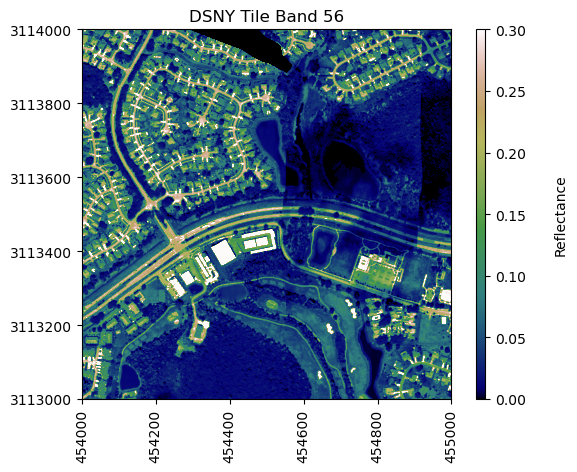

In [17]:
neon_hs.plot_aop_refl(band56/refl_metadata['scale_factor'],
                      refl_metadata['extent'],
                      colorlimit=(0,0.3),
                      title='DSNY Tile Band 56',
                      cmap_title='Reflectance',
                      colormap='gist_earth')

## RGB Plots - Band Stacking
It is often useful to look at several bands together. We can extract and stack three reflectance bands in the red, green, and blue (RGB) spectrums to produce a color image that looks like what we see with our eyes; this is your typical camera image. In the next part of this tutorial, we will learn to stack multiple bands and make a geotif raster from the compilation of these bands. We can see that different combinations of bands allow for different visualizations of the remotely-sensed objects and also conveys useful information about the chemical makeup of the Earth's surface. 

We will select bands that fall within the visible range of the electromagnetic spectrum (400-700 nm) and at specific points that correspond to what we see as red, green, and blue.

<figure>
	<a href="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/hyperspectral-general/spectrum_RGBcombined.png">
	<img src="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/hyperspectral-general/spectrum_RGBcombined.png" width = 600></a>
	<figcaption> NEON Imaging Spectrometer bands and their respective wavelengths. Source: National Ecological Observatory Network (NEON)  
	</figcaption>
</figure>

For this exercise, we'll first use the function `stack_rgb` to extract the bands we want to stack. This function uses splicing to extract the nth band from the reflectance array, and then uses the numpy function `stack` to create a new 3D array (1000 x 1000 x 3) consisting of only the three bands we want. 

In [18]:
# pull out the true-color band combinations
rgb_bands = (58,34,19) # set the red, green, and blue bands

# stack the 3-band combinations (rgb and cir) using stack_rgb function
rgb_unscaled = neon_hs.stack_rgb(refl,rgb_bands)

# apply the reflectance scale factor
rgb = rgb_unscaled/refl_metadata['scale_factor']

We can display the red, green, and blue band center wavelengths, whose indices were defined above. To confirm that these band indices correspond to wavelengths in the expected portion of the spectrum, we can print out the wavelength values in nanometers.

In [19]:
print('Center wavelengths:')
print('Band 58: %.1f' %(wavelengths[57]),'nm')
print('Band 33: %.1f' %(wavelengths[33]),'nm')
print('Band 19: %.1f' %(wavelengths[18]),'nm')

Center wavelengths:
Band 58: 669.3 nm
Band 33: 549.1 nm
Band 19: 474.0 nm


## plot_aop_rgb: plot an RGB band combination

Next, we can use the function `plot_aop_rgb` to plot the band stack as follows:

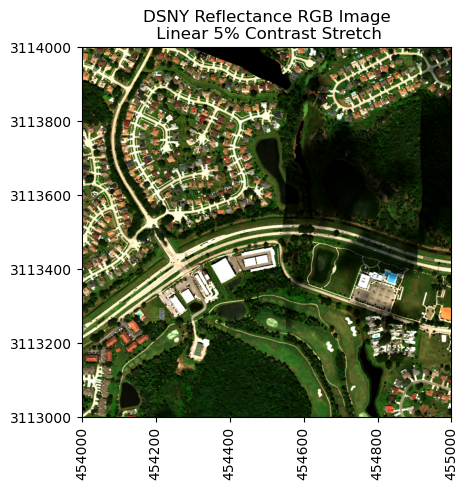

In [20]:
# plot the true color image (rgb)
neon_hs.plot_aop_rgb(rgb,
                     refl_metadata['extent'],
                     plot_title='DSNY Reflectance RGB Image')

## False Color Image - Color Infrared (CIR)
We can also create an image from bands outside of the visible spectrum. An image containing one or more bands outside of the visible range is called a **false-color image**. Here we'll use the green and blue bands as before, but we replace the red band with a near-infrared (NIR) band. 

For more information about non-visible wavelengths, false color images, and some frequently used false-color band combinations, refer to <a href="https://earthobservatory.nasa.gov/Features/FalseColor/" target="_blank">NASA's Earth Observatory page</a>.


Band 90 Center Wavelength = 829.6 nm
Band 34 Center Wavelength = 549.1 nm
Band 19 Center Wavelength = 474.0 nm


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


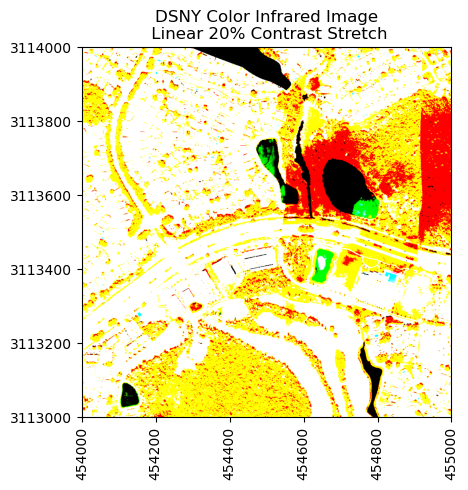

In [29]:
cir_bands = (90,34,19)
print('Band 90 Center Wavelength = %.1f' %(wavelengths[89]),'nm')
print('Band 34 Center Wavelength = %.1f' %(wavelengths[33]),'nm')
print('Band 19 Center Wavelength = %.1f' %(wavelengths[18]),'nm')

cir = neon_hs.stack_rgb(refl,cir_bands)
neon_hs.plot_aop_rgb(cir,
                     refl_metadata['extent'],
                     ls_pct=20,
                     plot_title='DSNY Color Infrared Image')

## References

Kekesi, Alex et al. 
<a href="https://svs.gsfc.nasa.gov/vis/a010000/a011400/a011491/" target="_blank"> "NASA | Peeling Back Landsat's Layers of Data". </a>
https://svs.gsfc.nasa.gov/vis/a010000/a011400/a011491/. Published on Feb 24, 2014.

Riebeek, Holli. 
<a href="https://earthobservatory.nasa.gov/Features/FalseColor/" target="_blank"> "Why is that Forest Red and that Cloud Blue? How to Interpret a False-Color Satellite Image" </a> 
https://earthobservatory.nasa.gov/Features/FalseColor/ 
